In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPool2D, Dropout, Flatten, Dense
import cv2
import pandas as pd
import random
import os
import ntpath
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.image as npimg
from imgaug import augmenters as iaa

In [ ]:
datadir = "Record-track-1"
columns = ["center", "left","right","steering","throttle","reverse","speed"]
data = pd.read_csv(os.path.join(datadir,"driving_log.csv"),names=columns)
pd.set_option('display.max_columns', 7)
print(data.head)


<bound method NDFrame.head of                                                  center  \
0     /Users/alexd/Documents/etudes/M1/S7/smart_tech...   
1     /Users/alexd/Documents/etudes/M1/S7/smart_tech...   
2     /Users/alexd/Documents/etudes/M1/S7/smart_tech...   
3     /Users/alexd/Documents/etudes/M1/S7/smart_tech...   
4     /Users/alexd/Documents/etudes/M1/S7/smart_tech...   
...                                                 ...   
1193  /Users/alexd/Documents/etudes/M1/S7/smart_tech...   
1194  /Users/alexd/Documents/etudes/M1/S7/smart_tech...   
1195  /Users/alexd/Documents/etudes/M1/S7/smart_tech...   
1196  /Users/alexd/Documents/etudes/M1/S7/smart_tech...   
1197  /Users/alexd/Documents/etudes/M1/S7/smart_tech...   

                                                   left  \
0     /Users/alexd/Documents/etudes/M1/S7/smart_tech...   
1     /Users/alexd/Documents/etudes/M1/S7/smart_tech...   
2     /Users/alexd/Documents/etudes/M1/S7/smart_tech...   
3     /Users/alexd/Docume

In [ ]:
def path_leaf(path):
  head,tail = ntpath.split(path)
  return tail

In [ ]:
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)

In [ ]:
print(data.head())

                               center                              left  \
0  center_2024_01_05_11_32_39_028.jpg  left_2024_01_05_11_32_39_028.jpg   
1  center_2024_01_05_11_32_39_106.jpg  left_2024_01_05_11_32_39_106.jpg   
2  center_2024_01_05_11_32_39_184.jpg  left_2024_01_05_11_32_39_184.jpg   
3  center_2024_01_05_11_32_39_263.jpg  left_2024_01_05_11_32_39_263.jpg   
4  center_2024_01_05_11_32_39_343.jpg  left_2024_01_05_11_32_39_343.jpg   

                               right  steering  throttle  reverse  \
0  right_2024_01_05_11_32_39_028.jpg       0.0       0.0        0   
1  right_2024_01_05_11_32_39_106.jpg       0.0       0.0        0   
2  right_2024_01_05_11_32_39_184.jpg       0.0       0.0        0   
3  right_2024_01_05_11_32_39_263.jpg       0.0       0.0        0   
4  right_2024_01_05_11_32_39_343.jpg       0.0       0.0        0   

          speed  
0  8.465614e-07  
1  1.011554e-05  
2  1.520549e-05  
3  3.981507e-05  
4  6.026511e-06  


### **Start of Pre Processing**

In [ ]:
num_bins = 25
samples_per_bin = 250
hist,bins = np.histogram(data['steering'],num_bins)
print(bins)

[-0.2656715  -0.24389881 -0.22212612 -0.20035342 -0.17858073 -0.15680804
 -0.13503535 -0.11326266 -0.09148996 -0.06971727 -0.04794458 -0.02617189
 -0.0043992   0.0173735   0.03914619  0.06091888  0.08269157  0.10446426
  0.12623696  0.14800965  0.16978234  0.19155503  0.21332772  0.23510042
  0.25687311  0.2786458 ]


[-0.25478515 -0.23301246 -0.21123977 -0.18946708 -0.16769439 -0.14592169
 -0.124149   -0.10237631 -0.08060362 -0.05883093 -0.03705823 -0.01528554
  0.00648715  0.02825984  0.05003253  0.07180523  0.09357792  0.11535061
  0.1371233   0.15889599  0.18066869  0.20244138  0.22421407  0.24598676
  0.26775945]


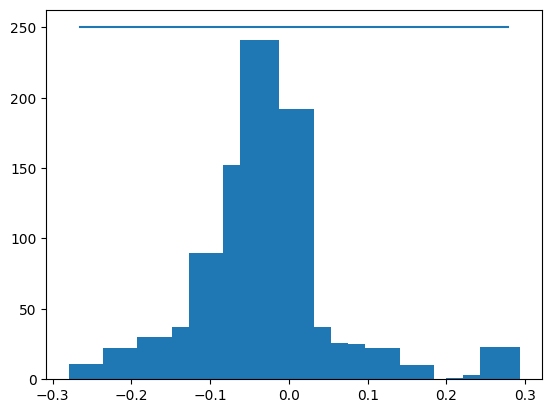

In [ ]:
centre = (bins[:-1] + bins[1:]) * 0.5
plt.bar(centre,hist,width=0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin,samples_per_bin))
print(centre)

In [ ]:
remove_list = []
print("Total Data: " , len(data))

Total Data:  1198


In [ ]:
for j in range(num_bins):
  list_ = []
  for i in range (len(data['steering'])):
    if bins[j] <= data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)


In [ ]:
print("Removed: ", len(remove_list))

Removed:  0


## **Actually Removing Data**

In [ ]:
data.drop(data.index[remove_list], inplace=True)
print("Remaining Data: ", len(data))

Remaining Data:  1198


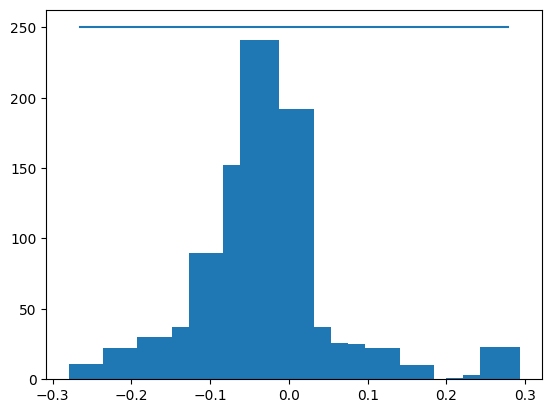

In [ ]:
hist, _ = np.histogram(data['steering'],num_bins)
plt.bar(centre,hist,width=0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin,samples_per_bin))

In [ ]:
# Training and Validation Split
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    centre,left,right = indexed_data[0], indexed_data[1],indexed_data[2]
    image_path.append(os.path.join(datadir,centre.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

In [ ]:
image_paths, steerings = load_img_steering(datadir+'/IMG',data)
X_train,X_valid,y_train,y_valid = train_test_split(image_paths,steerings,test_size=0.2,random_state=6)

In [ ]:
print("Training Samples: ", (len(X_train)),"Validation Samples: ", (len(X_valid)))

Training Samples:  958 Validation Samples:  240


Text(0.5, 1.0, 'Validation Set')

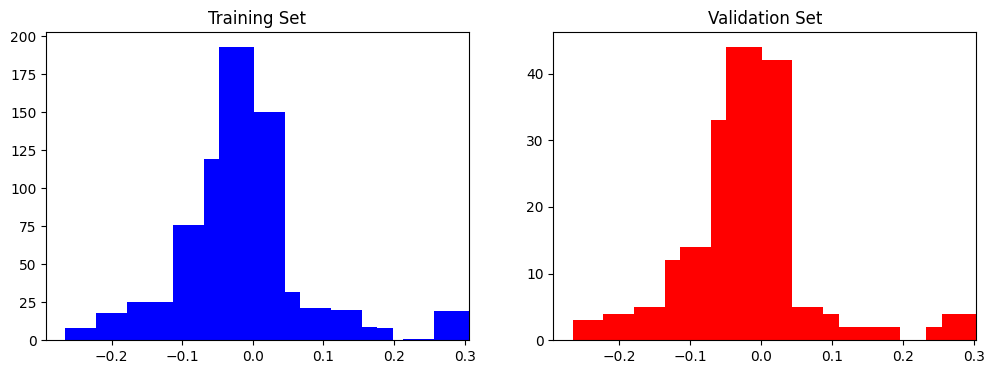

In [ ]:
fig,axes = plt.subplots(1,2,figsize = (12,4))
axes[0].hist(y_train,bins = num_bins, width=0.05,color='blue')
axes[0].set_title('Training Set')
axes[1].hist(y_valid,bins = num_bins, width=0.05,color='red')
axes[1].set_title('Validation Set')

In [ ]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

In [ ]:
image = image_paths[random.randint(0,1000)]
original_image = plt.imread(image)
zoomed_image = zoom(original_image)
fig,axes = plt.subplots(1,2,figsize = (12,4))
axes[0].imshow(original_image)
axes[0].set_title('Original image')
axes[1].imshow(zoomed_image)
axes[1].set_title('zoom image')

FileNotFoundError: [Errno 2] No such file or directory: 'Record-track-1/IMG/center_2024_01_05_11_33_37_275.jpg'

In [ ]:
def pan(image):
  pan = iaa.Affine(translate_percent={"x":(-0.1,0.1), "y":(-0.1, 0.1)})
  panned_image = pan.augment_image(image)
  return panned_image

In [ ]:
image = image_paths[random.randint(0,1000)]
original_image = plt.imread(image)
panned_image = pan(original_image)
fig,axes = plt.subplots(1,2,figsize = (12,4))
axes[0].imshow(original_image)
axes[0].set_title('Original image')
axes[1].imshow(panned_image)
axes[1].set_title('panned image')

In [ ]:
def img_random_brightness(image):
  brightness = iaa.Multiply((0.2, 1.2))
  image = brightness.augment_image(image)
  return image

In [ ]:
image = image_paths[random.randint(0,1000)]
original_image = plt.imread(image)
bright_image = img_random_brightness(original_image)
fig,axes = plt.subplots(1,2,figsize = (12,4))
axes[0].imshow(original_image)
axes[0].set_title('Original image')
axes[1].imshow(bright_image)
axes[1].set_title('bright image')

In [ ]:
def img_random_flip(image, steering_angle):
  image = cv2.flip(image, 1)
  steering_angle = -steering_angle
  return image, steering_angle


In [ ]:
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]
original_image = plt.imread(image)
flipped_image, flipped_steering = img_random_flip(original_image, steering_angle)
fig,axes = plt.subplots(1,2,figsize = (12,4))
axes[0].imshow(original_image)
axes[0].set_title('Original image + sterring angle ' + str(steering_angle))
axes[1].imshow(flipped_image)
axes[1].set_title('flipped image + sterring angle ' + str(flipped_steering))

In [ ]:
def random_augment(image, steering_angle):
  image = plt.imread(image)
  if np.random.rand() < 0.5:
    image = zoom(image)
  if np.random.rand() < 0.5:
    image = pan(image)
  if np.random.rand() < 0.5:
    image = img_random_brightness(image)
  if np.random.rand() < 0.5:
    image, steering_angle = img_random_flip(image, steering_angle)
  return image, steering_angle

In [ ]:
ncols = 2
nrows = 10
fig, axs = plt.subplots(nrows, ncols, figsize=(15, 50))
fig.tight_layout()
for i in range(10):
  rand_num = random.randint(0, len(image_paths)-1)
  random_image = image_paths[rand_num]
  random_steering = steerings[rand_num]
  original_image = plt.imread(random_image)
  augmented_image, steering_angle = random_augment(random_image, random_steering)
  axs[i][0].imshow(original_image)
  axs[i][0].set_title("original image")
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("augmented image")

In [ ]:
#Pre Proceess Images
def img_process(img):
  img = npimg.imread(img)
  img = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img,(3,3),0)
  img = cv2.resize(img,(200,66))
  img = img/255
  return img

In [ ]:
#Pre Proceess Images
def img_process_no_imread(img):
  img = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img,(3,3),0)
  img = cv2.resize(img,(200,66))
  img = img/255
  return img

In [ ]:
def batch_generator(image_paths, steering_angles, batch_size, is_training):
  while True:
    batch_img = []
    batch_steering = []
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths)-1)
      if is_training:
        im, steering = random_augment(image_paths[random_index], steering_angles[random_index])
      else:
        im = plt.imread(image_paths[random_index])
        steering = steering_angles[random_index]
      im = img_process_no_imread(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield(np.asarray(batch_img), np.asarray(batch_steering))

In [ ]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))
fig,axes = plt.subplots(1,2,figsize = (12,4))
axes[0].imshow(x_train_gen[0])
axes[0].set_title('Training image')
axes[1].imshow(x_valid_gen[0])
axes[1].set_title('Valid image')

In [ ]:
image = image_paths[149]
original_image = npimg.imread(image)
preprocessed_image = img_process(image)

In [ ]:
fig,axes = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title("Original Image")
axes[1].imshow(preprocessed_image)
axes[1].set_title("Preprocessed Image")

In [ ]:
# https;//arxiv.org/pdf/1604.07316v1.pdf

def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66,200, 3)))
  model.add(Convolution2D(36, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Convolution2D(48, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Convolution2D(64, kernel_size=(3,3), activation='elu'))
  model.add(Convolution2D(64, kernel_size=(3,3), activation='elu'))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(100, activation='elu'))
  model.add(Dropout(0.5))
  model.add(Dense(50, activation='elu'))
  model.add(Dropout(0.5))
  model.add(Dense(10, activation='elu'))
  model.add(Dropout(0.5))
  model.add(Dense(1))

  optimizer = Adam(learning_rate=0.001)
  model.compile(loss='mse', optimizer=optimizer)
  return model

In [ ]:
model = nvidia_model()
print(model.summary)

In [ ]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                              steps_per_epoch=300,
                              epochs=10,
                              validation_data=batch_generator(X_valid, y_valid, 100, 0),
                              validation_steps=200,
                              verbose=1,
                              shuffle=1)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', ])

In [ ]:
model.save('new_model.h5')